In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from data_cleaning import fill_missing_values, rename_columns
from data_science_skript import preprocess_data

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [2]:
df = pd.read_csv(r"C:\Kimi\Arbeit\Weiterbildung DADS\Stackfuel\Portfolio\PortfolioProject\.data\adult.csv", na_values=["?"]) 
df = fill_missing_values(df) 
df = rename_columns(df)

In [ ]:
# Diskriminierung beim Datensatz

plt.style.use('dark_background')  
colors = ["silver", "teal"]

# Einkommensverteilung nach Geschlecht
income_gender = df.groupby(['sex', 'income']).size().unstack()
income_gender.plot(kind='bar', stacked=True, color = colors, figsize=(8, 5))
plt.title("Einkommensverteilung nach Geschlecht")
plt.xlabel("Geschlecht")
plt.ylabel("Anzahl")
plt.xticks(rotation=0)
plt.legend(title="Einkommen")
plt.show()

# Einkommensverteilung nach Ethnie
income_race = df.groupby(['race', 'income']).size().unstack()
income_race.plot(kind='bar', stacked=True, color = colors, figsize=(10, 5))
plt.title("Einkommensverteilung nach Ethnie")
plt.xlabel("Ethnie")
plt.ylabel("Anzahl")
plt.xticks(rotation=45)
plt.legend(title="Einkommen")
plt.show()


In [ ]:
# Demographic Parity für Geschlecht
gender_parity = df[df['income'] == '>50K']['sex'].value_counts(normalize=True)
print(gender_parity)

# Demographic Parity für Ethnie
race_parity = df[df['income'] == '>50K']['race'].value_counts(normalize=True)
print(race_parity)

In [ ]:
sns.pairplot(df)

Dies deutet auf starke Unterschiede in der Einkommensverteilung hin und muss beim Feature-Engeneering mit beachtet werden
- Geschlecht und Ethnie sollte als sensible Merkmale beachtet werden
- verschiedene Korkkekturne: Reweightung, Fairness Constraints

### Fairness in der Vorhersage messen:
- Falsch Positive und Falsch Negativ messen
- Disparate Impact Score = Rate der pos Ergebnisse für die benachteiligten Gruppe / Rate der pos Ergebnisse für die bevorzugte Gruppe (>0.8)

# Modellauswahl
- Logistisches Modell 
- Decision Tree
- Random Forest
- Neuronale Netze?
### Fairness-optimierte Modelle
- Fair Logistic Regression

In [3]:
# Variablen umwandeln
df = preprocess_data(df)

<Axes: >

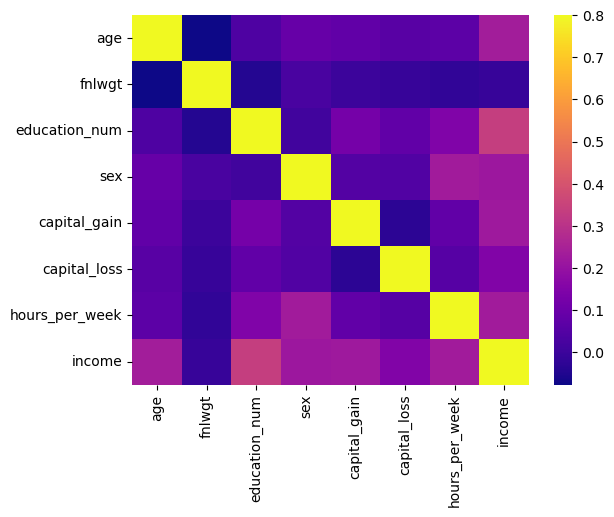

In [34]:
df_numeric = df.select_dtypes(include=["int64"])
sns.heatmap(df_numeric.corr(),cmap="plasma", vmax=0.8)

### Bewertung der Feature-Correlation
- education_num
- age
- sex, hours_per_week, age, income scheinen eine gewisse Korrelation zu haben

In [4]:
# Train-Test-Split
target = df["income"]
features = df.drop(columns=["income"])

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, stratify=target)

In [ ]:
print("Trainingsdaten:\n",features_train.shape)
print("\nTestdaten:\n",features_test.shape)

In [ ]:
df.dtypes

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=target_train, ax=ax[0])
ax[0].set_title("Klassenverteilung im Training-Set")

sns.countplot(x=target_test, ax=ax[1])
ax[1].set_title("Klassenverteilung im Test-Set")

plt.show()



In [6]:
train_crosstab_income = pd.crosstab(index=target_train, columns = "count", normalize = "columns")
test_crosstab_income = pd.crosstab(index=target_test, columns = "count", normalize = "columns")
display(train_crosstab_income)
display(test_crosstab_income)

col_0,count
income,
0,0.759175
1,0.240825


col_0,count
income,
0,0.759251
1,0.240749


### Kalssenverteilung
Es ist ein deutliches Ungleichgewicht der Zielkategorie zu erkennen:
- class_weight = balanced
- SMOTE

In [5]:
# Vorbereitung
num_cols = features_train.select_dtypes(include=["int64"]).columns
cat_cols = features_train.select_dtypes(include=["object"]).columns 

# Preprocessor
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(), cat_cols)
])

# Baselinemodell Logistische Regression

pipeline_log_base = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(class_weight="balanced", random_state = 42))
     ])

pipeline_log_base.fit(features_train,target_train)
target_pred_log_base = pipeline_log_base.predict(features_test)

print("Accuracy", accuracy_score(target_test, target_pred_log_base))
print("Classification report\n", classification_report(target_test, target_pred_log_base))

Accuracy 0.8083832335329342
Classification report
               precision    recall  f1-score   support

           0       0.94      0.80      0.86      4945
           1       0.57      0.85      0.68      1568

    accuracy                           0.81      6513
   macro avg       0.76      0.82      0.77      6513
weighted avg       0.85      0.81      0.82      6513



# Erste Bewertung 
Das Modell zeigt eine klare Diskriminierung:

### Precision
    - Einkommen > 50K werden ungenauer (nur mit 57% Wahrscheinlichkeit richtig vorhergesagt)
    --> Diskriminierung gegen zu hoch verdienende ?

### Recall
    - relativ gut und ausgeglichen

### F1-Score
    - auch hier werden Hochverdiener deutlich schlechter erkannt

### Ursachen:
- Datenungleichgewicht
- Feature Bias
- andere Modelle können eventuell besser unterscheiden (RandomForest)


In [19]:
features_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country'],
      dtype='object')

In [24]:
# Feature-Anpassung

crit_cols = ["sex", "race"]
features_train_crit = features_train.drop(columns=crit_cols)
features_test_crit = features_test.drop(columns=crit_cols)

num_cols_crit = features_train_crit.select_dtypes(include=["int64"]).columns
cat_cols_crit = features_train_crit.select_dtypes(include=["object"]).columns 

preprocessor_crit = ColumnTransformer([
    ("num", StandardScaler(), num_cols_crit),
    ("cat", OneHotEncoder(), cat_cols_crit)
])

pipeline_log_base_crit = Pipeline([
    ("preprocessor", preprocessor_crit),
    ("model", LogisticRegression(class_weight="balanced", random_state = 42))
     ])

pipeline_log_base_crit.fit(features_train_crit, target_train)
target_pred_log_base_crit = pipeline_log_base_crit.predict(features_test_crit)

print("LogistischeRegression\n", classification_report(target_test, target_pred_log_base_crit))

LogistischeRegression
               precision    recall  f1-score   support

           0       0.94      0.79      0.86      4945
           1       0.56      0.84      0.68      1568

    accuracy                           0.80      6513
   macro avg       0.75      0.82      0.77      6513
weighted avg       0.85      0.80      0.82      6513



Text(0.5, 1.0, "Feature Importance ohne 'sex' und 'race'")

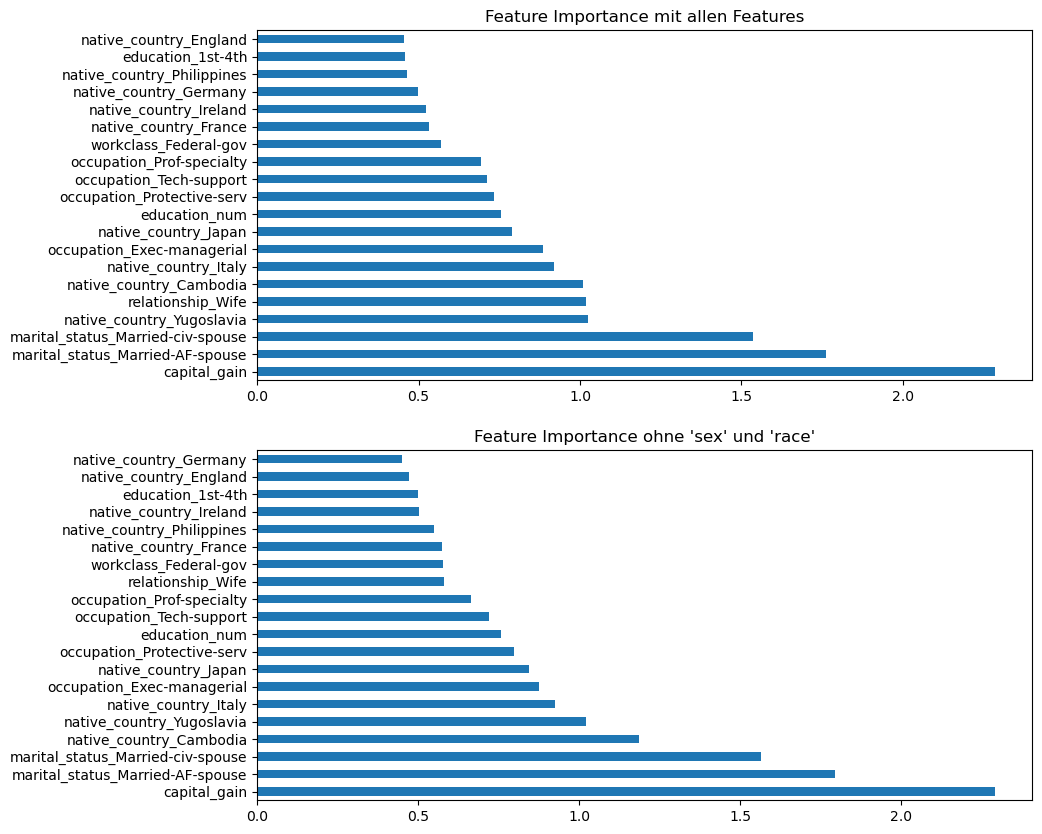

In [16]:
# Feature-Importance des Base-Line Modells
feature_names = list(num_cols) + list(pipeline_log_base.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols))
coefficients = pipeline_log_base.named_steps["model"].coef_[0]
feature_importance = pd.Series(data = pipeline_log_base.named_steps["model"].coef_[0],
                               index = feature_names).sort_values(ascending=False)
# Feature Importance OHNE sex and race
feature_names_crit = list(num_cols_crit) + list(pipeline_log_base_crit.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols_crit))
coefficients_crit = pipeline_log_base_crit.named_steps["model"].coef_[0]
feature_importance_crit = pd.Series(data = pipeline_log_base_crit.named_steps["model"].coef_[0],
                               index = feature_names_crit).sort_values(ascending=False)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 10)) 
feature_importance.head(20).plot(kind='barh', ax = ax[0])
feature_importance_crit.head(20).plot(kind='barh', ax = ax[1])

ax[0].set_title("Feature Importance mit allen Features")
ax[1].set_title("Feature Importance ohne 'sex' und 'race'")



### Bewertung der Feature-Importance
- Herkunftsländer scheinen eine auffällig große Rolle zu spielen
- das Geschlecht und die Rasse dafür nicht direkt.
- --> es gibt aber andere Metriken, die indirekt auf ein Geschlecht hinweisen(Education, Occupation, Relationship)

In [ ]:
# Fairness-Metriken berechnen für Geschlecht: 0 - Female / 1- Male

for group in features_test["sex"].unique():
    mask = (features_test["sex"] == group)
    acc = accuracy_score(target_test[mask], target_pred_log_base[mask])
    prec = precision_score(target_test[mask], target_pred_log_base[mask])
    rec = recall_score(target_test[mask], target_pred_log_base[mask])

    print(f"{group} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

0 - Accuracy: 0.913, Precision: 0.598, Recall: 0.747
1 - Accuracy: 0.756, Precision: 0.564, Recall: 0.867


In [21]:
# Fairness-Metriken für Ethnie

for group in features_test["race"].unique():  
    mask = (features_test["race"] == group)  
    
    acc = accuracy_score(target_test[mask], target_pred_log_base[mask])
    prec = precision_score(target_test[mask], target_pred_log_base[mask])
    rec = recall_score(target_test[mask], target_pred_log_base[mask])
    
    print(f"{group} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

White - Accuracy: 0.797, Precision: 0.569, Recall: 0.858
Amer-Indian-Eskimo - Accuracy: 0.877, Precision: 0.375, Recall: 0.600
Other - Accuracy: 0.923, Precision: 1.000, Recall: 0.429
Black - Accuracy: 0.901, Precision: 0.537, Recall: 0.750
Asian-Pac-Islander - Accuracy: 0.797, Precision: 0.603, Recall: 0.772


# Fazit zum ersten Baselinemodell Logistische Regression
## Geschlecht

#### Leichte Diskriminierung erkennbar:
Recall (Female: 74,7%, Male: 86,7%)
- Frauen, die tatsächlich Hochverdiener sind, werden schlechter erkannt (niedrigerer Recall)
- Männer haben einen höheren Recall, das heißt Männer werden besser als Hochverdiener erkannt

Accuracy (Female: 91,3%, Male: 75,6%):
- Frauen werden besser klassifiziert als Männer:
    - die meisten Frauen sind in der Kategorie <=50K
    - weitere Features deuten auf Frauen hin (Relationship)

Precision (Female: 59,8%, Male: 56,4%):
- Ergebnisse sind sehr ähnlich

## Ethnie
- Das Modell erkennt Hochverdiener aus bestimmten ethnischen Gruppen schlechter:
    - Recall für White besonders gut (85,8%) im Gegensatz zu indigenen und "other"
    - Precision für Indigene besonders schlecht
    -Precision für Other extrem gut - Datenset-Problem?

In [22]:
# DecisionTree
# Modell
pipeline_dt = Pipeline([
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])

#Anpassen des Modells
pipeline_dt.fit(features_train, target_train)

#Vorhersage
target_pred_dt = pipeline_dt.predict(features_test)

#Kennzahlen
print("DecisionTree:\n", classification_report(target_test, target_pred_dt))

DecisionTree:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      4945
           1       0.62      0.60      0.61      1568

    accuracy                           0.82      6513
   macro avg       0.75      0.74      0.75      6513
weighted avg       0.81      0.82      0.81      6513



In [23]:
# RandomForest
# Modell
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(class_weight="balanced", random_state=42))
])

#Anpassen des Modells
pipeline_rf.fit(features_train, target_train)

#Vorhersage
target_pred_rf = pipeline_rf.predict(features_test)

#Kennzahlen
print("RandomForest:\n", classification_report(target_test, target_pred_rf))

RandomForest:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      4945
           1       0.75      0.61      0.67      1568

    accuracy                           0.86      6513
   macro avg       0.82      0.77      0.79      6513
weighted avg       0.85      0.86      0.85      6513



Text(0.5, 1.0, 'Feature Importance Random Forest')

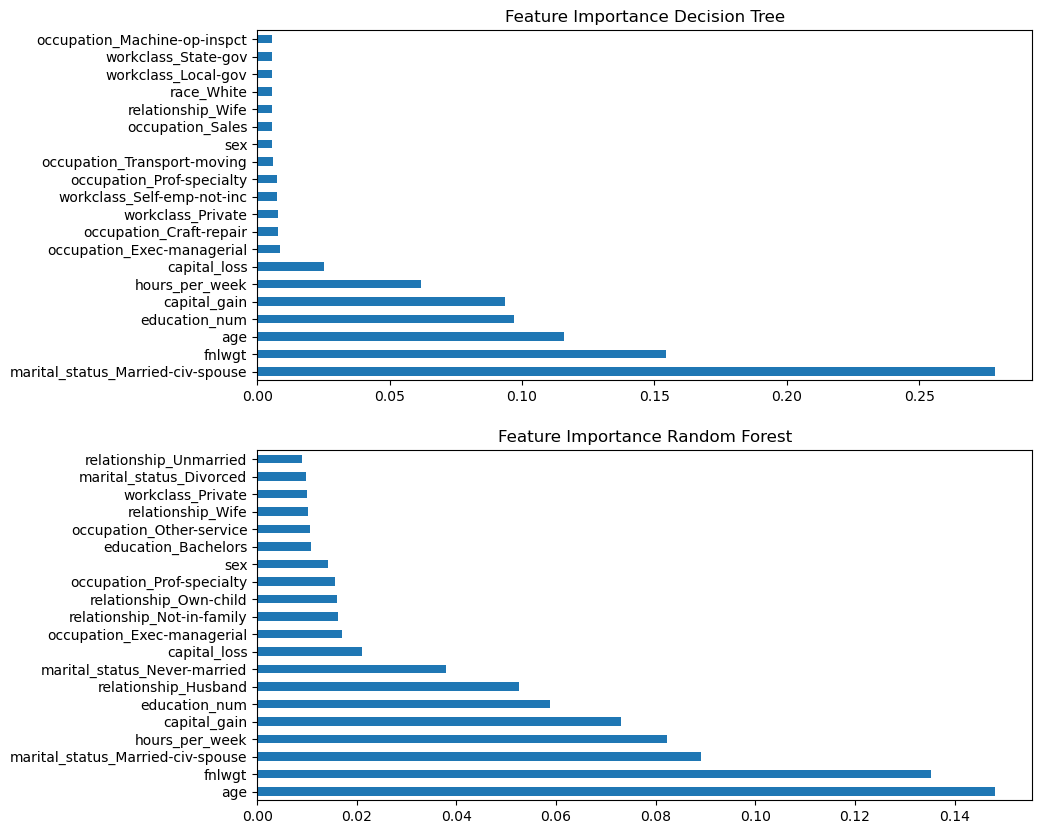

In [31]:
# Feature Importance
feature_names = list(num_cols) + list(pipeline_rf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols))

# Für den DecisionTree
feature_importance_dt = pd.Series(data=pipeline_dt.named_steps["model"].feature_importances_,
                               index=feature_names).sort_values(ascending=False)

#RandomForest
feature_importance_rf = pd.Series(data=pipeline_rf.named_steps["model"].feature_importances_,
                               index=feature_names).sort_values(ascending=False)


# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 10)) 
feature_importance_dt.head(20).plot(kind='barh', ax = ax[0])
feature_importance_rf.head(20).plot(kind='barh', ax = ax[1])

ax[0].set_title("Feature Importance Decision Tree")
ax[1].set_title("Feature Importance Random Forest")

In [30]:
# Fairness-Metriken für DecisionTree
# Fairness-Metriken berechnen für Geschlecht: 0 - Female / 1- Male
print("DecisionTree")
for group in features_test["sex"].unique():
    mask = (features_test["sex"] == group)
    acc = accuracy_score(target_test[mask], target_pred_dt[mask])
    prec = precision_score(target_test[mask], target_pred_dt[mask])
    rec = recall_score(target_test[mask], target_pred_dt[mask])

    print(f"{group} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

print("\n")
for group in features_test["race"].unique():  
    mask = (features_test["race"] == group)  
    
    acc = accuracy_score(target_test[mask], target_pred_dt[mask])
    prec = precision_score(target_test[mask], target_pred_dt[mask])
    rec = recall_score(target_test[mask], target_pred_dt[mask])
    
    print(f"{group} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

DecisionTree
0 - Accuracy: 0.902, Precision: 0.579, Recall: 0.558
1 - Accuracy: 0.772, Precision: 0.626, Recall: 0.613


White - Accuracy: 0.806, Precision: 0.626, Recall: 0.607
Amer-Indian-Eskimo - Accuracy: 0.877, Precision: 0.333, Recall: 0.400
Other - Accuracy: 0.885, Precision: 0.571, Recall: 0.571
Black - Accuracy: 0.900, Precision: 0.542, Recall: 0.574
Asian-Pac-Islander - Accuracy: 0.768, Precision: 0.574, Recall: 0.614


In [29]:
# Fairness-Metriken für RandomForest
# Fairness-Metriken berechnen für Geschlecht: 0 - Female / 1- Male
print("RandomForest")
for group in features_test["sex"].unique():
    mask = (features_test["sex"] == group)
    acc = accuracy_score(target_test[mask], target_pred_rf[mask])
    prec = precision_score(target_test[mask], target_pred_rf[mask])
    rec = recall_score(target_test[mask], target_pred_rf[mask])

    print(f"{group} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

print("\n")
for group in features_test["race"].unique():  
    mask = (features_test["race"] == group)  
    
    acc = accuracy_score(target_test[mask], target_pred_rf[mask])
    prec = precision_score(target_test[mask], target_pred_rf[mask])
    rec = recall_score(target_test[mask], target_pred_rf[mask])
    
    print(f"{group} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

RandomForest
0 - Accuracy: 0.927, Precision: 0.756, Recall: 0.546
1 - Accuracy: 0.821, Precision: 0.747, Recall: 0.619


White - Accuracy: 0.848, Precision: 0.749, Recall: 0.613
Amer-Indian-Eskimo - Accuracy: 0.965, Precision: 1.000, Recall: 0.600
Other - Accuracy: 0.885, Precision: 1.000, Recall: 0.143
Black - Accuracy: 0.935, Precision: 0.792, Recall: 0.559
Asian-Pac-Islander - Accuracy: 0.807, Precision: 0.673, Recall: 0.579
